In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from typing import Sequence
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit,random
from flax import linen as nn
import matplotlib.pyplot as plt

In [3]:
def npy_loader(path):
    return jnp.load(path)

In [4]:
input_data=npy_loader("/content/drive/My Drive/Colab Notebooks/cosmo.npy")
input_result=npy_loader("/content/drive/My Drive/Colab Notebooks/combined.npy")
x_train=jnp.stack((input_data[0:800,0],input_data[0:800,2]),axis=1)
y_train=input_result[0:800,:]
x_validate=jnp.stack((input_data[800:900,0],input_data[800:900,2]),axis=1)
y_validate=input_result[800:900,:]

In [5]:
class SimpleMLP(nn.Module):
    features:Sequence[int]

    @nn.compact
    def __call__(self,inputs):
        x=inputs
        for i,feat in enumerate(self.features):
            x=nn.Dense(feat)(x)
            if i != len(self.features)-1:
                x=nn.relu(x)
        return x

In [6]:
layer_sizes=[64,256,256,256]
learning_rate=1e-6
epochs=200000
model=SimpleMLP(features=layer_sizes)
temp=jnp.ones(2)
params=model.init(random.PRNGKey(0),temp)
tx=optax.adam(learning_rate=learning_rate,b1=0.9,b2=0.999)
opt_state=tx.init(params)

In [7]:
@jit
def mse_loss(params,x,y_ref):
    preds=model.apply(params,x)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [8]:
@jit
def train_step(params,opt_state,x,y_ref):
    loss,grads=jax.value_and_grad(mse_loss,argnums=0)(params,x,y_ref)
    updates,opt_state=tx.update(grads,opt_state)
    params=optax.apply_updates(params,updates)
    return loss,params,opt_state

In [9]:
@jit
def epoch_step(x_train,y_train,params,opt_state,order):
    order=random.permutation(random.PRNGKey(i),order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)-1],:]
        y_batch=y_train[order[32*j:32*(j+1)-1],:]
        loss,params,opt_state=train_step(params,opt_state,x_batch,y_batch)
        train_loss=train_loss+loss
    return train_loss,params

100 0.105350286
200 0.056187432
300 0.020108193
400 0.0051054014
500 0.003657887
600 0.003428912
700 0.0032583368
800 0.0031253456
900 0.003012141
1000 0.002909955
1100 0.0028134887
1200 0.0027195434
1300 0.0026276028
1400 0.002537012
1500 0.002447435
1600 0.002358641
1700 0.002270023
1800 0.002181161
1900 0.0020920527
2000 0.0020011663
2100 0.0019095527
2200 0.0018177801
2300 0.001724256
2400 0.0016283646
2500 0.0015298062
2600 0.0014276874
2700 0.0013225598
2800 0.001214108
2900 0.0011062382
3000 0.0009978455
3100 0.0008890201
3200 0.00078349095
3300 0.00067858543
3400 0.0005772718
3500 0.00047973602
3600 0.00038901158
3700 0.0003053127
3800 0.00023213385
3900 0.00016937572
4000 0.000119617376
4100 8.2660146e-05
4200 5.6268414e-05
4300 3.8538452e-05
4400 2.7196198e-05
4500 2.032369e-05
4600 1.6386904e-05
4700 1.3798838e-05
4800 1.1978331e-05
4900 1.0593657e-05
5000 9.500316e-06
5100 8.633705e-06
5200 7.887208e-06
5300 7.223947e-06
5400 6.6039956e-06
5500 6.052056e-06
5600 5.5455653e-

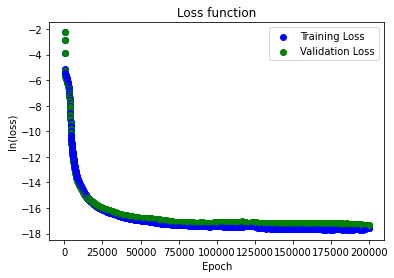

In [10]:
order=jnp.arange(800)
for i in range(epochs):
    train_loss,params=epoch_step(x_train,y_train,params,opt_state,order)
    if i % 100 == 99:
        train_loss=train_loss/25
        validate_loss=mse_loss(params,x_validate,y_validate)
        print((i+1),validate_loss)
        plt.scatter((i+1),jnp.log(train_loss),c='b')
        plt.scatter((i+1),jnp.log(validate_loss),c='g')
print("Training ended")
jnp.save("/content/drive/My Drive/Colab Notebooks/model.npy",params)
plt.xlabel("Epoch")
plt.ylabel("ln(loss)")
plt.title("Loss function")
plt.legend(["Training Loss","Validation Loss"])
plt.savefig("/content/drive/My Drive/Colab Notebooks/loss.png")
drive.flush_and_unmount()

In [11]:
x_test=jnp.stack((input_data[900:1000,0],input_data[900:1000,2]),axis=1)
y_test=input_result[900:1000,:]
y_pred=model.apply(params,x_test)
print(y_pred)
error=abs(y_pred/y_test-1)
print("Max error =",jnp.max(error)*100,"%")

[[0.0119019  0.011882   0.01226664 ... 0.9758826  0.9882617  1.0002148 ]
 [0.01270622 0.01282757 0.01313851 ... 0.9789172  0.9895158  1.0000204 ]
 [0.01397263 0.01423995 0.01450292 ... 0.9835168  0.9917555  0.9998011 ]
 ...
 [0.01427312 0.0143987  0.01466802 ... 0.98335207 0.99171394 0.9999568 ]
 [0.0157347  0.01602766 0.01629994 ... 0.98680425 0.99336666 0.9998186 ]
 [0.01208952 0.01253973 0.01256335 ... 0.97677916 0.9883008  0.9996373 ]]
Max error = 3.2405317 %
